In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from quickndirtybot import io
from quickndirtybot.strategies import minmax
from quickndirtybot import backtest


Index(['time', 'open', 'highest', 'lowest', 'closing', 'volume', 'sma-hi-now',
       'sma-lo-now', 'sma-hi-prev', 'sma-lo-prev', 'min-hi-prev',
       'max-lo-prev', 'max/min', 'buy', 'sell', 'USD', 'BTC', 'dUSD', 'dBTC',
       'tot_USD', 'tot_USD_cons', 'tot_BTC', 'return_on_inv_perc'],
      dtype='object')


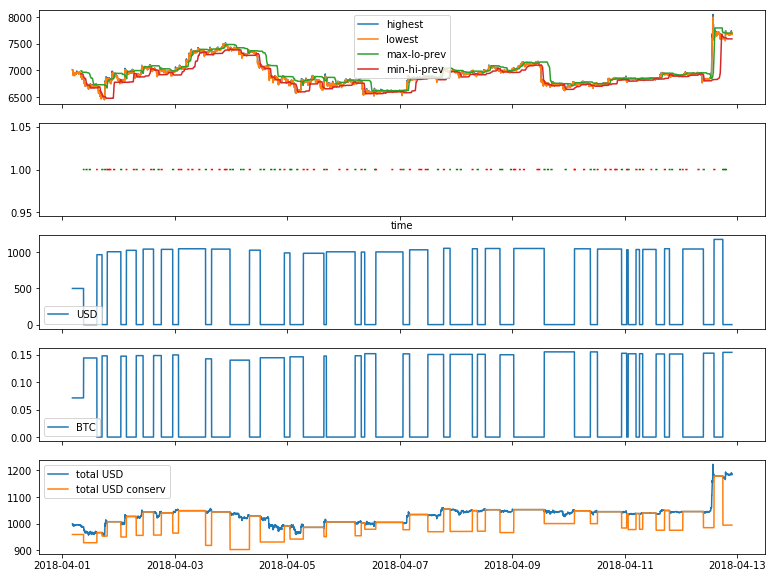

--------------------
end balance: 0.00 USD + 0.15425 BTC which equates 1184.61 USD or 0.15425 BTC
further results
{'investment': 999.9996434950322, 'return_on_inv_perc': 18.461539281473893, 'roi_per_day': 1.4553337617268403, 'nrbuys': 986.0, 'nrsells': 1055.0, 'transactions': 53, 'buy_hold': 9.514112595596735, 'vs_buy_hold': 8.947426685877158, 'vs_buy_hold_per_day': 0.6772446079887473}


In [8]:
# plot performance of minmax
minmaxpars_smaperiod = 20
minmaxpars_minmaxperiod = 180
minmaxpars_threshold = 1.0001
minmaxpars_takerfee = 0.003

# enablo zooming into fig
%matplotlib inline
import mpld3
mpld3.enable_notebook()

data = io.load_csv('../data/gdax_data.csv')
df = io.pandize_csv(data)

minmax.measure(df, smaperiod=minmaxpars_smaperiod, minmaxperiod=minmaxpars_minmaxperiod)
minmax.findbuy(df, thresh_maxovermin=minmaxpars_threshold)
minmax.findsell(df, thresh_maxovermin=minmaxpars_threshold)

backtest.set_start_funds(df, 1000, True)
backtest.backtest(df, amount_buy=5, amount_sell=5, taker_fee=minmaxpars_takerfee)
results = backtest.diagnose(df)

# output
print(df.columns)
# print(df)
# fig = plt.gcf()
# ax = plt.gca()

fig, ax = plt.subplots(nrows=5, sharex=True)
# subplot 0: prices

time = df['time'].map(lambda x: datetime.fromtimestamp(x/1000))
# time = datetime.fromtimestamp(df['time'])
ax[0].plot(time, df['highest'], label='highest')
ax[0].plot(time, df['lowest'], label='lowest')
ax[0].plot(time, df['max-lo-prev'], label='max-lo-prev')
ax[0].plot(time, df['min-hi-prev'], label='min-hi-prev')
ax[0].legend()
# subplot 1: buy/sell decisions
ax[1].plot(time, df['buy'], color='g')
ax[1].plot(time, df['sell'], color='r')
ax[1].set_xlabel('time')
# subplot 2: USD funds
ax[2].plot(time, df['USD'], label='USD')
ax[2].legend()
# subplot 3: BTC funds
# ax2r = ax[2].twinx()
# ax2r.plot(df['time'], df['BTC'], label='BTC')
ax[3].plot(time, df['BTC'], label='BTC')
ax[3].legend()
# subplot 4: total depot value
ax[4].plot(time, df['tot_USD'], label='total USD')
ax[4].plot(time, df['tot_USD_cons'], label='total USD conserv')
ax[4].legend()
fig.set_size_inches(13, 10)

plt.show()

print('-'*20)
endUSD = df.loc[len(df)-1, 'USD']
endBTC = df.loc[len(df)-1, 'BTC']
endtotUSD =  df.loc[len(df)-1, 'tot_USD']
endtotBTC =  df.loc[len(df)-1, 'tot_BTC']

print('end balance: {:.2f} USD + {:.5f} BTC'.format(endUSD, endBTC),
      'which equates {:.2f} USD or {:.5f} BTC'.format(endtotUSD, endtotBTC))
print('further results')
print(results)

In [ ]:
# test various sma- and minmax period parameters
# on split data to see variance
split_num = 8
smaperiods = [1, 2, 3, 5, 10, 15, 20, 40, 60, 120, 240]
minmaxperiods = [2, 5, 10, 20, 30, 60, 120, 180, 240, 300, 400]
threshold = 1.0001
takerfee = 0.003


data_all = io.load_csv('../data/gdax_data.csv')
data_split = io.split_data(data_all, split_num)

roi_results = {}
for smaperiod in smaperiods:
    empt = {'minmaxperiods': [], 'roi_per_day': [], 'transactions':[], 'vs_buy_hold_per_day':[]}
    roi_results[smaperiod] = {'minmaxperiods': [], 'roi_per_day': [], 'transactions':[], 'vs_buy_hold_per_day':[]}
    roi_results[smaperiod]['means'] = {'minmaxperiods': [], 'roi_per_day': [], 'transactions':[], 'vs_buy_hold_per_day':[]}
    for minmaxperiod in minmaxperiods:
        roipd = []
        trans = []
        vsbh = []
        for data in data_split:
            df = io.pandize_csv(data)

            minmax.measure(df, smaperiod=smaperiod, minmaxperiod=minmaxperiod)
            minmax.findbuy(df, thresh_maxovermin=threshold)
            minmax.findsell(df, thresh_maxovermin=threshold)

            backtest.set_start_funds(df, 1000, True)
            backtest.backtest(df, amount_buy=5, amount_sell=5, taker_fee=takerfee)
            results = backtest.diagnose(df)
            roi_results[smaperiod]['minmaxperiods'].append(minmaxperiod)
            roi_results[smaperiod]['roi_per_day'].append(results['roi_per_day'])
            roi_results[smaperiod]['transactions'].append(results['transactions'])
            roi_results[smaperiod]['vs_buy_hold_per_day'].append(results['vs_buy_hold_per_day'])
            roipd.append(results['roi_per_day'])
            trans.append(results['transactions'])
            vsbh.append(results['vs_buy_hold_per_day'])
        roi_results[smaperiod]['means']['roi_per_day'].append(np.mean(roipd))
        roi_results[smaperiod]['means']['transactions'].append(np.mean(trans))
        roi_results[smaperiod]['means']['vs_buy_hold_per_day'].append(np.mean(vsbh))
    print('done sma', smaperiod)
print('done all. ready to plot')

In [ ]:
# plot results multiparameter search

# enablo zooming into fig
%matplotlib inline
import mpld3
mpld3.enable_notebook()

fig, ax = plt.subplots(nrows=3, sharex=True)
# plot
for idx, (colname, results) in enumerate(roi_results.items()):
    delta = .1*idx
    ax[0].plot(np.array(results['minmaxperiods'])+delta,
               np.array(results['roi_per_day']),
               label=colname, marker='x', linewidth=0)
    ax[0].plot(np.array(minmaxperiods)+delta,
               results['means']['roi_per_day'], label=colname)
    ax[1].plot(np.array(results['minmaxperiods'])+delta,
               np.array(results['transactions']),
               label=colname, marker='x', linewidth=0)
    ax[1].plot(np.array(minmaxperiods)+delta,
               np.array(results['means']['transactions']), label=colname)
    ax[2].plot(np.array(results['minmaxperiods'])+delta,
               np.array(results['vs_buy_hold_per_day']),
               label=colname, marker='x', linewidth=0)
    ax[2].plot(np.array(minmaxperiods)+delta,
               np.array(results['means']['vs_buy_hold_per_day']), label=colname)
#     ax[3].plot(np.array(minmaxperiods), np.prod(np.array(results['roi_per_day'])+1, axis=0), label=colname, marker='x')
ax[0].set_ylabel('return on inv per day')
ax[0].legend()
ax[1].set_ylabel('transactions')
ax[2].set_ylabel('vs_buy_hold_per_day')
ax[2].set_xlabel('minmaxperiods')
# ax[3].set_xlabel('minmaxperiods')
# ax[3].set_ylabel('total roi')
fig.set_size_inches(13, 10)


In [ ]:
# zoom in onto most promising parameter pair
smaperiod_best = 15
minmaxperiod_best = 180

fig, ax = plt.subplots(nrows=1)
idxs = np.argwhere(np.array(roi_results[smaperiod_best]['minmaxperiods'])==minmaxperiod_best)

buy_hold_per_day = (np.array(roi_results[smaperiod_best]['roi_per_day'])[idxs] -
                    np.array(roi_results[smaperiod_best]['vs_buy_hold_per_day'])[idxs])[:, 0]
roi_pd = np.array(roi_results[smaperiod_best]['roi_per_day'])[idxs][:, 0]
ax.plot(buy_hold_per_day, roi_pd, marker='x', linewidth=0, label='roi per day')
ax.plot(buy_hold_per_day, np.array(roi_results[smaperiod_best]['vs_buy_hold_per_day'])[idxs],
        marker='x', linewidth=0, label='vs buy hold per day')
ax.set_xlabel('buy hold per day')
ax.set_ylabel('val')
ax.legend()
plt.show()